In [1]:
# Cell 1 ‑‑‑ imports and cube loading
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

In [2]:


# --------- file location (edit if needed) ----------
cube_path = Path("/g/data/jh2/rh2802/ICRAR/data/NGC4064/NGC4064_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
print("Loading:", cube_path.resolve())

with fits.open(cube_path) as hdul:
    data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
    stat = hdul["STAT"].data.astype(np.float32)
    dq   = hdul["DQ"].data.astype(np.uint8)
    hdr  = hdul["DATA"].header

nz, ny, nx = data.shape
print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
hdr


Loading: /g/data/jh2/rh2802/ICRAR/data/NGC4064/NGC4064_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits
Cube dimensions  →  nz = 3761,  ny = 665,  nx = 566


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  566                                                  
NAXIS2  =                  665                                                  
NAXIS3  =                 3761                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      210.34029489253 / Pixel coordinate of reference point            
CRPIX2  =      212.02984260033 / Pixel coordinate of reference point            
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             

In [3]:
# Cell 2  –– wavelength array (Å), λ‑cut, velocity scale
from astropy.wcs import WCS

# --- 2.1 build wavelength array in Å ---
wcs_3d = WCS(hdr)                       # 3‑D WCS (RA, Dec, λ)
spec_pix = np.arange(nz)                # spectral pixel indices (0 … nz‑1)
lam_min = 4750.0                     # min λ in Å
lam_max = 7050.0                     # max λ in Å

# all_pix2world returns metres for the spectral axis in this cube → convert to Å
lam_m  = wcs_3d.all_pix2world(
             np.zeros_like(spec_pix),   # dummy RA
             np.zeros_like(spec_pix),   # dummy Dec
             spec_pix,                  # spectral pixel
             0)[2]                      # wavelength [m]
lam_ang = lam_m * 1e10                  # metres → Å

# --- 2.2 keep only λ < 7000 Å ---
cut = (lam_ang >= lam_min) & (lam_ang <= lam_max)
lam_ang = lam_ang[cut]
data    = data[cut, :, :]
stat    = stat[cut, :, :]
dq      = dq[cut,   :, :]
nz      = lam_ang.size                 # update nz after trimming
print(f"After λ‑cut (<=7000 Å)  →  nz = {nz}")

# --- 2.3 compute velocity scale (km s⁻¹ per pixel) ---
c_kms   = c.c.to(u.km/u.s).value        # 299 792.458
dlnλ    = np.diff(np.log(lam_ang))  # dlnλ in Å
velscale = np.min(c_kms * dlnλ) # km/s per pixel
print(f"Velocity scale (min)  →  velscale = {velscale:.2f} km/s")


After λ‑cut (<=7000 Å)  →  nz = 1841
Velocity scale (min)  →  velscale = 53.16 km/s


Integrated spectrum built:
   simple‑sum shape    : (1841,)


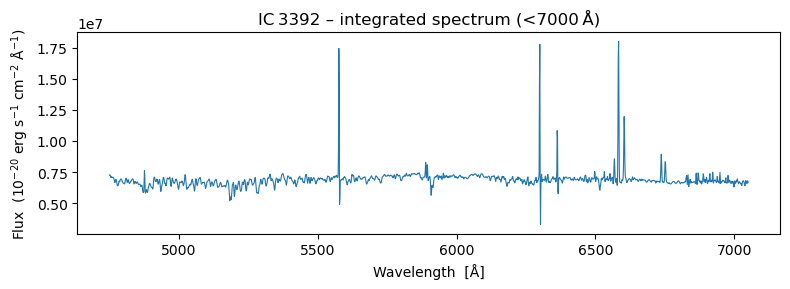

Integrated spectrum normalised:
Normalisation factor: 1


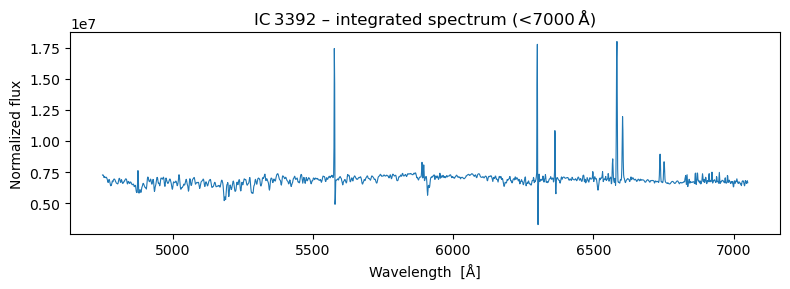

In [4]:
# Cell 3 –– integrate cube to 1‑D spectrum + noise  (v2: NaN‑safe)
# ----------------------------------------------------------------

# ---- 3.1 simple‑sum spectrum ----
flux_sum  = np.nansum(data, axis=(1, 2))          # erg s⁻¹ cm⁻² Å⁻¹
noise_wgt = np.sqrt(np.nansum(stat, axis=(1, 2)))  # shape = (nz,)

print("Integrated spectrum built:")
print(f"   simple‑sum shape    : {flux_sum.shape}")

# ---- 3.2 quick plot ----
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel(r"Flux  ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)")
plt.title("IC 3392 – integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()

# ---- 3.3 normalized the flux to be near unity ----
# normalize to the median of the spectrum
# normalisation = np.nanmedian(flux_sum)
normalisation = 1
flux_sum /= normalisation
noise_wgt /= normalisation
print("Integrated spectrum normalised:")
print("Normalisation factor:", normalisation)

# ---- 3.4 normalized plot ----
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.8)
plt.xlabel("Wavelength  [Å]")
plt.ylabel("Normalized flux")
plt.title("IC 3392 – integrated spectrum (<7000 Å)")
plt.tight_layout();  plt.show()

Hα‑based red‑shift  z = 0.00319   (v ≈ 957.0 km/s)
Masked wavelength bins : 306 of 1841 (16.6 %)


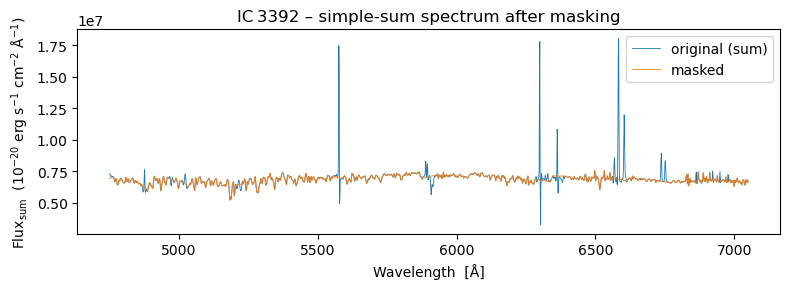

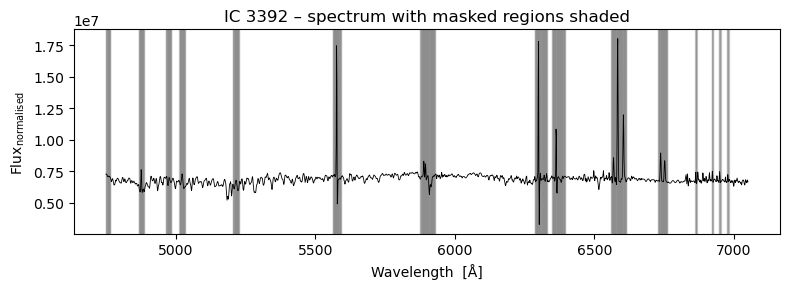

In [5]:
# Cell 4 –– red‑shift guess & dual‑spectra masking (sky ≠ red‑shifted)
# -------------------------------------------------------------------
import numpy as np

# -- 4.1  red‑shift from Hα using the simple‑sum spectrum --------------
h_alpha_lab = 6562.8
win = (lam_ang > 6500) & (lam_ang < 6700)
lam_peak = lam_ang[win][np.nanargmax(flux_sum[win])]
z_guess  = lam_peak / h_alpha_lab - 1
v_guess  = z_guess * c_kms
print(f"Hα‑based red‑shift  z = {z_guess:.5f}   (v ≈ {v_guess:.1f} km/s)")

# -- 4.2  read mask table ------------------------------------------------
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_tbl  = np.genfromtxt("/g/data/jh2/rh2802/ICRAR/data/IC3392/specMask_KIN.txt", dtype=mask_dtype,
                          comments='#', usecols=(0,1,2), encoding=None)

# -- 4.3  construct bad‑pixel mask --------------------------------------
mask_bad = np.zeros_like(lam_ang, dtype=bool)

for lam_rest, width_rest, comment in mask_tbl:
    # sky lines: use rest value directly (no z shift)
    if comment.strip().lower() == 'sky':
        lam_obs   = lam_rest
        width_obs = width_rest
    else:                       # nebular/emission lines → red‑shifted
        lam_obs   = lam_rest  * (1 + z_guess)
        width_obs = width_rest * (1 + z_guess)

    m = (lam_ang > lam_obs - width_obs/2) & (lam_ang < lam_obs + width_obs/2)
    mask_bad |= m

print(f"Masked wavelength bins : {mask_bad.sum()} of {lam_ang.size} "
      f"({100*mask_bad.mean():.1f} %)")

# --- 4.4 replace masked pixels with local mean along the wavelength axis ---

def fill_bad_1d(spec, bad):
    """
    spec : 1‑D array  (your flux vector)
    bad  : 1‑D bool   (True where you want to replace)
    Returns a *new* array with bad entries replaced by the
    mean of the nearest good pixels on either side.
    """
    filled = spec.copy()

    if bad.any():
        good = ~bad
        # np.interp does linear interpolation; for a single pixel gap
        # that is exactly the mean of its two neighbours
        filled[bad] = np.interp(np.flatnonzero(bad),         # x  to fill
                                np.flatnonzero(good),        # x of neighbours
                                spec[good])                  # y of neighbours
    return filled

# 1‑D masks (length = nz)
bad_1d = mask_bad.copy()

flux_sum_masked = fill_bad_1d(flux_sum, bad_1d)

# keep the noise = ∞ so pPXF still gives zero weight there
noise_wgt_masked = noise_wgt.copy()
noise_wgt_masked[bad_1d] = np.inf

# -- 4.5  quick visual check -----------------------
plt.figure(figsize=(8,3))
plt.plot(lam_ang, flux_sum,        lw=0.6, label='original (sum)')
plt.plot(lam_ang, flux_sum_masked, lw=0.8, label='masked', alpha=0.8)
plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{sum}$  (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title('IC 3392 – simple‑sum spectrum after masking')
plt.legend();  plt.tight_layout();  plt.show()

# Extract the region that we maks out
lam_ang_masked = lam_ang[bad_1d]
flux_sum_masked = flux_sum_masked[bad_1d]

# ---- outputs for Cell 5 ----
# lam_ang, flux_wgt_masked, noise_wgt_masked, flux_sum_masked

# after building mask_bad:
lam_remove = lam_ang[mask_bad]
lam_good   = lam_ang[~mask_bad]
# Plot the spectrum with the reomve regions with vertical gray shading 
plt.figure(figsize=(8, 3))
plt.plot(lam_ang, flux_sum, lw=0.6, color = 'black', label='original (sum)')
# shade out the removed wavelength bins
half_bin = np.diff(lam_ang).mean() / 2
for lam in lam_remove:
    plt.axvspan(lam - half_bin, lam + half_bin, color='gray', alpha=0.3)

plt.xlabel('Wavelength  [Å]')
plt.ylabel(r'Flux$_\mathrm{normalised}$')
plt.title('IC 3392 – spectrum with masked regions shaded')
plt.tight_layout()
plt.show()

In [6]:
# Cell 5 –– log‑rebinning the chosen 1‑D spectrum
# -----------------------------------------------
from ppxf import ppxf_util

# ----- 5.0  get spectrum -----

flux_1d_raw  = flux_sum
# noise from summed variances (shot‑noise approximation)
noise_1d_raw = np.sqrt(np.nansum(stat, axis=(1,2)))



# --- log‑rebin flux and noise -----------------------------------
# 5.2a  initial rebin just to measure velscale_out
_, _, velscale_out = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw, velscale=velscale, flux=True)

#  rebin flux & noise *with* the measured velscale_out
log_flux, log_lam, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw,
    velscale=velscale_out, flux=True)

log_noise, _, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], noise_1d_raw,
    velscale=velscale_out, flux=False)

# log_rebin for lam_good
_, log_lam_good, _ = ppxf_util.log_rebin(
    [lam_ang[0], lam_ang[-1]], flux_1d_raw,
    velscale=velscale_out, flux=True)



print(f"Log‑grid length : {log_flux.size} pixels")
print(f"velscale        : {velscale_out:.3f} km/s")

assert np.isclose(velscale_out, velscale), \
       "Warning: velscale mismatch! Check your data."

# ---- outputs for the next cell ----
#   log_flux, log_noise, log_lam, velscale_out, z_guess


Log‑grid length : 2228 pixels
velscale        : 53.159 km/s


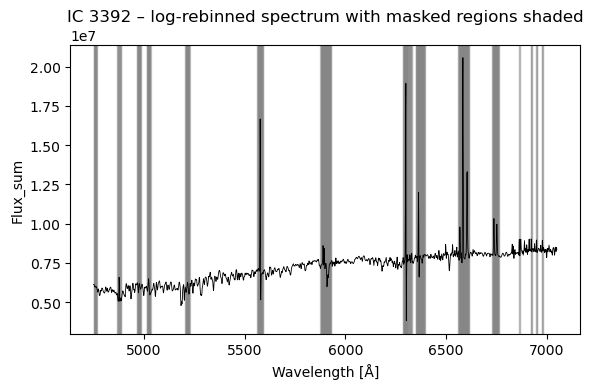

In [7]:
plt.figure(figsize=(6,4))
lam_plot = np.exp(log_lam)
plt.plot(lam_plot, log_flux, 'k-', lw=0.6)
half_bin = np.diff(lam_plot).mean() / 2
for lam in lam_remove:
    plt.axvspan(lam - half_bin, lam + half_bin, color='gray', alpha=0.3)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux_sum')
plt.title('IC 3392 – log‐rebinned spectrum with masked regions shaded')
plt.tight_layout()
plt.show()


In [8]:
# Setup SPS templates

# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

FWHM_gal = None   # set this to None to skip templates broadening
print("Loading E‑MILES SSP grid …")
# sps = lib.sps_lib(filename, velscale_out, fwhm_gal=None,
#                   norm_range=[lam_min, 7000]
#                   )    

lam_temp_arr = np.arange(lam_min, lam_max+1, dtype=int)
 
fwhm_gal = {
    "lam": lam_temp_arr,
    "fwhm": 5.866e-8 * lam_temp_arr**2 
            - 9.187e-4 * lam_temp_arr 
            + 6.040
}

sps = lib.sps_lib(
    filename, velscale_out, fwhm_gal,
    norm_range=[lam_min, lam_max],
    # lam_range=[lam_min, lam_max+10],
)

sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar

templates_hr = sps.templates          # (n_wave, n_age, n_Z)
lam_temp_hr  = sps.lam_temp           # length 18 998 Å

print(f"Template wavelength range: {sps.lam_temp[0]:.1f} to {sps.lam_temp[-1]:.1f} Å")

Loading E‑MILES SSP grid …
Template wavelength range: 1679.9 to 49996.0 Å


 Best Fit:       Vel     sigma
 comp.  0:       932        62
chi2/DOF: 1792.; DOF: 1859; degree = 12; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 112/150
V = 931.748 km/s,  σ = 61.972 km/s


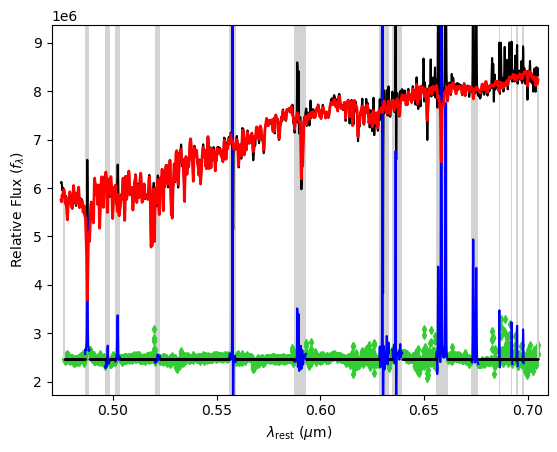

In [9]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
regul_err = 0.1  # Large regularization error

# Compute which rebinned pixels fall on unmasked (good) λ
lam_grid = np.exp(log_lam)                   # rebinned wavelengths in Å
pix      = np.searchsorted(lam_ang, lam_grid)
goodpixels = np.where(~mask_bad[pix])[0]

# Run pPXF only on those good pixels
from ppxf import ppxf

start_V   = v_guess
start_sig = 5 * velscale_out

pp = ppxf.ppxf(
    templates   = sps.templates,
    # templates   = stars_templates,
    galaxy      = log_flux,
    noise       = log_noise,
    velscale    = velscale_out,
    start       = [start_V, start_sig],
    degree      = 12,
    mdegree     = 0,
    moments     = 2,
    # clean       = True,
    goodpixels  = goodpixels,
    lam         = np.e**(log_lam),
    lam_temp    = sps.lam_temp, 
    regul       = 1/regul_err, 
    reg_dim     = reg_dim,
    plot        = True)

print(f"V = {pp.sol[0]:.3f} km/s,  σ = {pp.sol[1]:.3f} km/s")

In [10]:
log_flux

array([6111630.3395019 , 6120802.71577811, 6128416.63539888, ...,
       8382080.97245678, 8478758.73613941, 8335847.26567869],
      shape=(2228,))

In [11]:
log_noise

array([5625.97167969, 5056.57496073, 4515.20621255, ..., 1878.74285153,
       1896.6246716 , 1719.15209091], shape=(2228,))

In [12]:
# Check S/N ratio
snr = (log_flux[goodpixels] / log_noise[goodpixels])
print(f"Mean S/N ratio: {snr.mean():.1e} ± {snr.std():.1e}")
print(f"Median S/N ratio: {np.median(snr):.1e} ± {np.std(snr):.1e}")
print(f"Min S/N ratio: {snr.min():.1e} ± {snr.std():.1e}")
print(f"Max S/N ratio: {snr.max():.1e} ± {snr.std():.1e}")


Mean S/N ratio: 3.4e+03 ± 9.1e+02
Median S/N ratio: 3.3e+03 ± 9.1e+02
Min S/N ratio: 1.7e+03 ± 9.1e+02
Max S/N ratio: 5.6e+03 ± 9.1e+02


In [13]:
# #
# # ------------------------------------------------------

# import numpy as np
# from astropy import units as u, constants as c

# # ---------- Galaxy continuum luminosity from the fit --------------
# # Get fitted redshift
# z_fit = pp.sol[0] / c_kms
# print(f"Fitted redshift  : {z_fit:.5f}")

# D = 17 * u.Mpc                                      # Virgo distance
# erg_to_Lsun = (1*u.erg/u.s / c.L_sun).to('').value      # 2.613×10⁻³⁴

# F_lambda = log_flux * 1e-20 * normalisation                             # erg s⁻¹ cm⁻² Å⁻¹
# L_lambda = F_lambda * 4*np.pi*(D.to('cm').value)**2 * erg_to_Lsun   # L☉ Å⁻¹
# L_gal    = np.trapezoid(L_lambda, np.exp(log_lam))          # L☉
# print(f"log L  (aperture) : log({np.log10(L_gal):.3f}  L☉)")

# # ---------- Composite M/L from pPXF weights ------------------------
# weights = pp.weights.reshape(reg_dim)/pp.weights.sum()                                           # enforce Σw = 1

# ML_r = sps.mass_to_light(weights, band="DECam_r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
# print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

# # ---------- Physical stellar mass inside the MUSE aperture --------
# from speclite import filters
# f_r   = filters.load_filter('decamDR1-r')
# lam_r = f_r.wavelength
# R_r   = f_r.response

# # best-fit continuum in erg s⁻¹ cm⁻² Å⁻¹
# cont_flux = pp.bestfit * 1e-20 * normalisation

# # best‑fit continuum in physical units (L_sun Å⁻¹)
# cont_L = cont_flux * 4*np.pi*(D.to('cm').value)**2 * erg_to_Lsun

# #    cont_flux [erg s⁻¹ cm⁻² Å⁻¹] at instrument wavelengths range
# flux_at_lam_r = np.interp(lam_r, log_lam, cont_flux)

# # integrate the best‑fit spectrum over the r‑band filter
# L_r    = np.trapezoid( np.interp(lam_r, log_lam, cont_L) * R_r, lam_r )  # L_sun

# # r band apparent AB magnitude

# # Compute the AB magnitude
# m_r = f_r.get_ab_magnitude(
#     flux_at_lam_r * u.erg / (u.cm**2 * u.s * u.AA),
#     wavelength=lam_r
# )

# print(f"r-band apparent AB mag = {m_r:.2f}")

# # M/L in r-band
# M_star = ML_r * L_r

# print(f"Log L  (r-band)   : log({np.log10(L_r):.3f}  L☉)")
# print(f"log M_star        : log({np.log10(M_star):.3f}  M☉)")


In [27]:
z_fit = pp.sol[0] / c_kms
print(f"Fitted redshift  : {z_fit:.5f}")
# # ---------- Composite M/L from pPXF weights ------------------------
weights = pp.weights.reshape(reg_dim)/pp.weights.sum()    
ML_r = sps.mass_to_light(weights, band="DECam_r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

D = 8.5 * u.Mpc                                      # Virgo distance

from speclite import filters
f_r   = filters.load_filter('decamDR1-r')
lam_r = f_r.wavelength
R_r   = f_r.response

# best-fit continuum in erg s⁻¹ cm⁻² Å⁻¹
cont_flux = pp.bestfit * 1e-20 * normalisation

#    cont_flux [erg s⁻¹ cm⁻² Å⁻¹] at instrument wavelengths range
flux_at_lam_r = np.interp(lam_r, log_lam, cont_flux)

# Compute the AB magnitude
m_r = f_r.get_ab_magnitude(
    flux_at_lam_r * u.erg / (u.cm**2 * u.s * u.AA),
    wavelength=lam_r
)

print(f"r-band apparent AB mag = {m_r:.2f}")

# Compute absolute magnitude
M_r = m_r - 5 * np.log10(D.to(u.pc).value / 10)

# Solar AB magnitude in r‐band
M_sun_r = ppxf_util.mag_sun(bands="DECam_r", redshift=z_fit, system="AB")[0]

# Luminosity in solar units
L_r_sun = 10**(-0.4 * (M_r - M_sun_r))
print(f"Absolute M_r = {M_r:.2f}, M_sun,r = {M_sun_r:.2f}")
print(f"r-band luminosity = {L_r_sun:.3e} L_sun = log({np.log10(L_r_sun):.3f} L☉)")

# If you want the physical luminosity in erg/s:
L_r = L_r_sun * c.L_sun
print(f"r-band luminosity = {L_r:.3e}")

# Given that we know the mass-to-light ratio, we can compute the stellar mass
M_star = ML_r * L_r_sun
print(f"Log M_star        : log({np.log10(M_star):.3f}  M☉)")

Fitted redshift  : 0.00311
(M*/L)=0.9411 (DECam_r at z=0.0031)
M/L (r band)  : 0.941  M☉/L☉ = log(-0.026  M☉/L☉)
r-band apparent AB mag = 11.27
Absolute M_r = -18.38, M_sun,r = 4.61
r-band luminosity = 1.579e+09 L_sun = log(9.198 L☉)
r-band luminosity = 6.046e+35 W
Log M_star        : log(9.172  M☉)


In [28]:
z_fit = pp.sol[0] / c_kms
print(f"Fitted redshift  : {z_fit:.5f}")
# # ---------- Composite M/L from pPXF weights ------------------------
weights = pp.weights.reshape(reg_dim)/pp.weights.sum()    
ML_r = sps.mass_to_light(weights, band="SDSS/r", redshift=z_fit,)                     # intrinsic M/L (dimensionless)
print(f"M/L (r band)  : {ML_r:.3f}  M☉/L☉ = log({np.log10(ML_r):.3f}  M☉/L☉)")

D = 8.5 * u.Mpc                                      # Virgo distance

from speclite import filters
f_r   = filters.load_filter('sdss2010-r')
lam_r = f_r.wavelength
R_r   = f_r.response

# best-fit continuum in erg s⁻¹ cm⁻² Å⁻¹
cont_flux = pp.bestfit * 1e-20 * normalisation

#    cont_flux [erg s⁻¹ cm⁻² Å⁻¹] at instrument wavelengths range
flux_at_lam_r = np.interp(lam_r, log_lam, cont_flux)

# Compute the AB magnitude
m_r = f_r.get_ab_magnitude(
    flux_at_lam_r * u.erg / (u.cm**2 * u.s * u.AA),
    wavelength=lam_r
)

print(f"r-band apparent AB mag = {m_r:.2f}")

# Compute absolute magnitude
M_r = m_r - 5 * np.log10(D.to(u.pc).value / 10)

# Solar AB magnitude in r‐band
M_sun_r = ppxf_util.mag_sun(bands="SDSS/r", redshift=z_fit, system="AB")[0]

# Luminosity in solar units
L_r_sun = 10**(-0.4 * (M_r - M_sun_r))
print(f"Absolute M_r = {M_r:.2f}, M_sun,r = {M_sun_r:.2f}")
print(f"r-band luminosity = {L_r_sun:.3e} L_sun = log({np.log10(L_r_sun):.3f} L☉)")

# If you want the physical luminosity in erg/s:
L_r = L_r_sun * c.L_sun
print(f"r-band luminosity = {L_r:.3e}")

# Given that we know the mass-to-light ratio, we can compute the stellar mass
M_star = ML_r * L_r_sun
print(f"Log M_star        : log({np.log10(M_star):.3f}  M☉)")

Fitted redshift  : 0.00311
(M*/L)=0.9627 (SDSS/r at z=0.0031)
M/L (r band)  : 0.963  M☉/L☉ = log(-0.017  M☉/L☉)
r-band apparent AB mag = 11.35
Absolute M_r = -18.30, M_sun,r = 4.64
r-band luminosity = 1.502e+09 L_sun = log(9.177 L☉)
r-band luminosity = 5.750e+35 W
Log M_star        : log(9.160  M☉)


In [16]:
lam_r.shape

(86,)

In [17]:
np.trapezoid(log_flux, np.e**log_lam) # 10**-20 cm-2 erg s-1

np.float64(16595367336.719574)

In [18]:
(np.trapezoid(flux_sum, lam_ang)*1e-20*u.erg/u.s*(4*np.pi*D**2)/u.cm**2).to(u.W)/c.L_sun # cm-2 

<Quantity 6.54663443e+08>

In [19]:
(np.dot(flux_sum, lam_ang)*1e-20*u.erg/u.s*(4*np.pi*D**2)/u.cm**2).to(u.W)/c.L_sun

<Quantity 3.09674868e+12>

In [20]:
sps.mean_age_metal(weights)

Weighted <lg_age> [yr]: 9.43
Weighted <[M/H]>: -0.189


(np.float64(9.433373186185598), np.float64(-0.1886674132226333))

In [21]:
sps.mass_to_light(weights, band="DECam_i", redshift=z_fit,) 

(M*/L)=0.7875 (DECam_i at z=0.0031)


np.float64(0.78749997047731)

In [22]:
ppxf_util.mag_sun(bands="SDSS/r", redshift=z_fit, system = "AB") 

array([4.6433143])

In [23]:
filters.load_filters('decam2014-*').names

['decam2014-u',
 'decam2014-g',
 'decam2014-r',
 'decam2014-i',
 'decam2014-z',
 'decam2014-Y']

In [24]:
#    cont_flux [erg s⁻¹ cm⁻² Å⁻¹] at wavelengths lam_obs = exp(log_lam)
lam_obs       = np.exp(log_lam)
flux_at_lam_r = np.interp(lam_r, lam_obs, cont_flux)

# 3) Compute the AB magnitude
m_r = f_r.get_ab_magnitude(
    flux_at_lam_r * u.erg / (u.cm**2 * u.s * u.AA),
    wavelength=lam_r
)

print(f"r-band apparent AB mag = {m_r:.2f}")

r-band apparent AB mag = 11.44


In [25]:
pp.weights.sum()

np.float64(1905390.1727066762)

In [26]:
# sps.mass_to_light(weights, band="SDSS/v", redshift=pp.sol[0]/c_kms,)